In [1]:
%matplotlib inline

In [2]:
import json
import os
import sqlite3
import sys
import pickle
import numpy as np
import pandas as pd

In [3]:
TP_file = 'train_triplets.txt'
md_dbfile = 'track_metadata.db'

In [4]:
tp = pd.read_table(TP_file, header=None, names=['uid', 'sid', 'count'])

In [5]:
MIN_USER_COUNT = 20
MIN_SONG_COUNT = 50

### Keep play counts that involve only usable tracks

In [7]:
# tid2sid.json contains a mapping between track id and song id, which can obtained from track_metadata.db
with open('tid2sid.json', 'r') as f:
    tid2sid = json.load(f)

In [8]:
bad_audio = []

with open('tracks_bad_audio.txt', 'r') as f:
    for line in f:
        bad_audio.append(line.strip())

In [9]:
bad_sid = [tid2sid[k] for k in bad_audio]

In [10]:
def filter_usable_tracks(tp, bad_sid):
    return tp[~tp['sid'].isin(bad_sid)]

tp_good = filter_usable_tracks(tp, bad_sid)

In [11]:
print '%d playcount triplets are kept out of %d'% (len(tp_good), len(tp))

46968690 playcount triplets are kept out of 48373586


### Further filter out counts invoving inactive users & songs

In [12]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id, 'count']].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

def remove_inactive(tp, min_uc=MIN_USER_COUNT, min_sc=MIN_SONG_COUNT):
    # Only keep the triplets for songs which were listened to by at least min_sc users. 
    songcount = get_count(tp, 'sid')
    tp = tp[tp['sid'].isin(songcount.index[songcount >= min_sc])]
    
    # Only keep the triplets for users who listened to at least min_uc songs
    # After doing this, some of the songs will have less than min_uc users, but should only be a small proportion
    usercount = get_count(tp, 'uid')
    tp = tp[tp['uid'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and songcount after filtering
    usercount, songcount = get_count(tp, 'uid'), get_count(tp, 'sid') 
    return tp, usercount, songcount

In [13]:
tp, usercount, songcount = remove_inactive(tp_good)

In [14]:
sparsity_level = float(tp.shape[0]) / (usercount.shape[0] * songcount.shape[0])
print "After filtering, there are %d triplets from %d users and %d songs (sparsity level %.3f%%)" % (tp.shape[0], 
                                                                                                      usercount.shape[0], 
                                                                                                      songcount.shape[0], 
                                                                                                      sparsity_level * 100)

After filtering, there are 38226302 triplets from 613682 users and 97414 songs (sparsity level 0.064%)


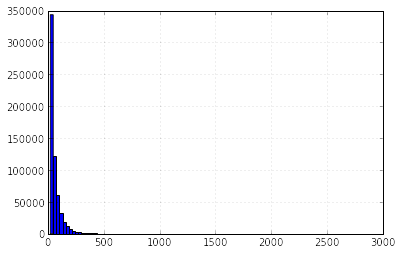

In [15]:
usercount.hist(bins=100)

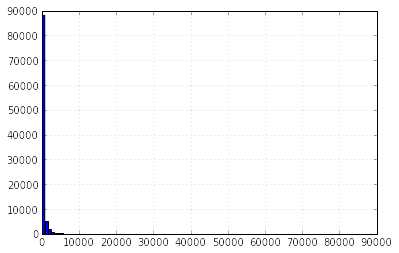

In [16]:
songcount.hist(bins=100)

In [17]:
songcount.sort(ascending=False)

In [18]:
def get_song_info_from_sid(conn, sid):
    cur = conn.cursor()
    cur.execute("SELECT title, artist_name FROM songs WHERE song_id = '%s'" % (sid))
    title, artist = cur.fetchone()
    return title, artist

In [19]:
# take a look at the top 50 most listened songs
with sqlite3.connect(os.path.join(MSD_ADD, md_dbfile)) as conn:
    for i in xrange(50):
        sid = songcount.index[i]
        title, artist = get_song_info_from_sid(conn, sid)
        print "%s BY %s -- count: %d" % (title, artist, songcount[i])

Sehr kosmisch BY Harmonia -- count: 80277
Dog Days Are Over (Radio Edit) BY Florence + The Machine -- count: 71975
Undo BY Björk -- count: 63486
Secrets BY OneRepublic -- count: 60764
You're The One BY Dwight Yoakam -- count: 60062
Revelry BY Kings Of Leon -- count: 59131
Fireflies BY Charttraxx Karaoke -- count: 50561
Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile) BY Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner -- count: 50029
Hey_ Soul Sister BY Train -- count: 50013
Tive Sim BY Cartola -- count: 44583
OMG BY Usher featuring will.i.am -- count: 41360
Drop The World BY Lil Wayne / Eminem -- count: 39214
The Scientist BY Coldplay -- count: 38856
Canada BY Five Iron Frenzy -- count: 37666
Clocks BY Coldplay -- count: 36879
Marry Me BY Train -- count: 36732
Catch You Baby (Steve Pitron & Max Sanna Radio Edit) BY Lonnie Gordon -- count: 35097
Pursuit Of Happiness (nightmare) BY Kid Cudi / MGMT / Ratatat -- count: 34032
Lucky (Album Version) B

## Generate in- and out-of-matrix split

#### Get all users & songs in filtered taste profile, shuffle them, and map to integer indices

In [20]:
playcount = tp[['sid', 'count']]   

In [21]:
playcount_groupbysid = playcount.groupby('sid', as_index=False)

In [22]:
songcount = playcount_groupbysid.sum().sort('count', ascending=False)
print songcount

                      sid   count
6147   SOBONKR12A58A7A7E0  530291
3174   SOAUWYT12A81C206F1  462084
72395  SOSXLTC12AF72A7F54  381805
22489  SOFRQTD12A81C233C0  318278
3524   SOAXGDH12A8C13F8A1  293453
16885  SOEGIYH12A6D4FC0E3  287323
54300  SONYKOW12AB01849C9  232204
61043  SOPUCYA12A8C13A694  231973
77055  SOUFTBI12AB0183F65  203117
55382  SOOFYTN12A6D4F9B35  186374
30671  SOHTKMO12AB01843B0  183617
80275  SOVDSJC12A58A7A271  177617
6192   SOBOUPA12A6D4F81F1  175260
13465  SODJWHY12A8C142CCE  166712
44144  SOLFXKT12AB017E3E0  157726
73078  SOTCMDJ12A6D4F8528  155002
21564  SOFLJQZ12A6D4FADA6  146176
75813  SOTWNDJ12A8C143984  136096
78205  SOUNZHU12A8AE47481  123716
78843  SOUSMXX12AB0185C24  121482
79277  SOUVTSM12AC468F6A7  119187
41186  SOKLRPJ12A8C13C3FE  110497
66762  SORJICW12A8C13640D  106462
6080   SOBOAFP12A8C131F36  106053
60813  SOPSOHT12A67AE0235  105932
83973  SOWEHOM12A6BD4E09E  103151
76755  SOUDLVN12AAFF43658  103042
60403  SOPPROJ12AB0184E18  101875
11269  SOCVTLJ

In [23]:
unique_sid = pd.unique(tp['sid'])
n_songs = len(unique_sid)
# Shuffle songs
np.random.seed(98765)
idx = np.random.permutation(np.arange(n_songs))
unique_sid = unique_sid[idx]

In [24]:
print n_songs
unique_uid = pd.unique(tp['uid'])

97414


In [25]:
# Map song/user ID to indices
song2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
user2id = dict((uid, i) for (i, uid) in enumerate(unique_uid))

In [26]:
with open('unique_uid.txt', 'w') as f:
    for uid in unique_uid:
        f.write('%s\n' % uid)
        
with open('unique_sid.txt', 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)
        
with open('song2id.json', 'w') as f:
    json.dump(song2id, f)

with open('user2id.json', 'w') as f:
    json.dump(user2id, f)

#### Select 5% songs for out-of-matrix prediction

In [30]:
in_sid = unique_sid[:int(0.95 * n_songs)]
out_sid = unique_sid[int(0.95 * n_songs):]

In [31]:
print out_sid.shape

(4871,)


In [32]:
out_tp = tp[tp['sid'].isin(out_sid)]
out_tp

,uid,sid,count
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
50,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SONRXOY12AB0181E84,1
96,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOXRXDG12A8C131DE5,1
110,85c1f87fea955d09b4bec2e36aee110927aedf9a,SOHANDU12A8C13C47F,1
120,85c1f87fea955d09b4bec2e36aee110927aedf9a,SOTVFEF12AF729E6CE,3
123,85c1f87fea955d09b4bec2e36aee110927aedf9a,SOUSQUG12A8C13616F,2
158,969cc6fb74e076a68e36a04409cb9d3765757508,SOGFUFC12A8C13F1E5,6
266,b64cdd1a0bd907e5e00b39e345194768e330d652,SOCBRSN12AAF3B30A6,2
268,b64cdd1a0bd907e5e00b39e345194768e330d652,SOCSISN12AF72AB1DE,2
275,b64cdd1a0bd907e5e00b39e345194768e330d652,SOEWYLX12A6D4F8E5F,3


In [33]:
in_tp = tp[~tp['sid'].isin(out_sid)]
in_tp

,uid,sid,count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1
10,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
11,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOCNMUH12A6D4F6E6D,1
12,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


## Generate train/test/vad sets

Pick out 20% of the rating for in-matrix prediction

In [34]:
np.random.seed(12345)
n_ratings = in_tp.shape[0]
test = np.random.choice(n_ratings, size=int(0.20 * n_ratings), replace=False)

In [35]:
test_idx = np.zeros(n_ratings, dtype=bool)
test_idx[test] = True

test_tp = in_tp[test_idx]
train_tp = in_tp[~test_idx]

Make sure there is no empty row or column in the training data

In [36]:
print len(pd.unique(train_tp['uid']))
print len(pd.unique(in_tp['uid']))

613682
613682


In [37]:
print len(pd.unique(train_tp['sid']))
print len(pd.unique(in_tp['sid']))

92543
92543


Pick out 10% of the training rating as validation set

In [38]:
np.random.seed(13579)
n_ratings = train_tp.shape[0]
vad = np.random.choice(n_ratings, size=int(0.10 * n_ratings), replace=False)

In [39]:
vad_idx = np.zeros(n_ratings, dtype=bool)
vad_idx[vad] = True

vad_tp = train_tp[vad_idx]
train_tp = train_tp[~vad_idx]

In [40]:
print len(pd.unique(train_tp['uid']))
print len(pd.unique(in_tp['uid']))

613682
613682


In [41]:
print len(pd.unique(train_tp['sid']))
print len(pd.unique(in_tp['sid']))

92543
92543


In [42]:
test_tp.to_csv('in.test.csv', index=False)

In [43]:
train_tp.to_csv('in.train.csv', index=False)

In [44]:
vad_tp.to_csv('in.vad.csv', index=False)

In [45]:
out_tp.to_csv('out.test.csv', index=False)